# TP - 02

Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [ ]:
# Importación de módulos estándar de Python
import json
import logging
import os
import random as rd
import re
import string
from io import StringIO
from pathlib import Path

# Importación de bibliotecas científicas y de análisis de datos
import numpy as np
import pandas as pd

# Importación de bibliotecas para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Importación de bibliotecas de machine learning y procesamiento de texto
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from keras.preprocessing.text import text_to_word_sequence
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, pairwise as cosine_similarity
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# Otras importaciones
import gdown
import multiprocessing
import pickle

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np


## Preprocesamiento con NLTK (Natural Language Toolkit)

In [ ]:
simple_text = "if she leaves now she might miss something important!"
large_text = "Patients who in late middle age have smoked 20 cigarettes a day since their teens constitute an at-risk group. One thing they’re clearly at risk for is the acute sense of guilt that a clinician can incite, which immediately makes a consultation tense."

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Descargar tokenizador punkt
nltk.download("punkt")
# Descargar la red de semántica del inglés WordNet, es una extensa red semántica que puede usarse para hacer POS tagging o lematizar.
nltk.download("wordnet")
# Descargar diccionario de stopwords del inglés
nltk.download('stopwords')
# Para usar NLTK 3.6.6 o superior es necesario instalar OMW 1.4
# (Open Multilingual WordNet)
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Instanciar el derivador, NLTK provee varios derivadores para elegir: https://www.nltk.org/api/nltk.stem.html
from nltk.stem.porter import *
p_stemmer = PorterStemmer()

In [ ]:
# Instanciar el lematizador
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# Ejemplo de extraer los tokens de un doc
tokens = word_tokenize(simple_text)
print("Tokens:", tokens)

Tokens: ['if', 'she', 'leaves', 'now', 'she', 'might', 'miss', 'something', 'important', '!']


In [ ]:
# Transformar los tokens a sus respectivas palabras derivadas
# Stemming
nltk_stemedList = []
for word in tokens:
    nltk_stemedList.append(p_stemmer.stem(word))
print("Stemming:", nltk_stemedList)

Stemming: ['if', 'she', 'leav', 'now', 'she', 'might', 'miss', 'someth', 'import', '!']


In [ ]:
# Transformar los tokens a sus respectivas palabras raiz
# Lemmatization
nltk_lemmaList = []
for word in tokens:
    nltk_lemmaList.append(lemmatizer.lemmatize(word))
print("Lemmatization:", nltk_lemmaList)

Lemmatization: ['if', 'she', 'leaf', 'now', 'she', 'might', 'miss', 'something', 'important', '!']


In [ ]:
# Quitar los signos de puntuacion
nltk_punctuation = [w for w in nltk_lemmaList if w not in string.punctuation]
print("Punctuation filter:", nltk_punctuation)

Punctuation filter: ['if', 'she', 'leaf', 'now', 'she', 'might', 'miss', 'something', 'important']


In [ ]:
nltk_stop_words = set(stopwords.words("english"))
len(nltk_stop_words)

179

In [ ]:
# Filtrar stopwords
nltk_stop_words = set(stopwords.words("english"))
filtered_sentence = [w for w in nltk_punctuation if w not in nltk_stop_words]
print("Stop words filter:", filtered_sentence)

Stop words filter: ['leaf', 'might', 'miss', 'something', 'important']


🤖 Proceso completo con NLTK
Tokenization → Lemmatization → Remove stopwords → Remove punctuation

In [ ]:
def nltk_process(text):
    # Tokenization
    nltk_tokenList = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in nltk_tokenList:
        nltk_lemmaList.append(lemmatizer.lemmatize(word))

    print("Lemmatization")
    print(nltk_lemmaList)

    # Stop words
    nltk_stop_words = set(stopwords.words("english"))
    filtered_sentence = [w for w in nltk_lemmaList if w not in nltk_stop_words]

    # Filter Punctuation
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    print(" ")
    print("Remove stopword & Punctuation")
    print(filtered_sentence)
    return filtered_sentence

In [ ]:
nltk_text = nltk_process(large_text)
print("Text len:", len(nltk_text))

Lemmatization
['Patients', 'who', 'in', 'late', 'middle', 'age', 'have', 'smoked', '20', 'cigarette', 'a', 'day', 'since', 'their', 'teen', 'constitute', 'an', 'at-risk', 'group', '.', 'One', 'thing', 'they', '’', 're', 'clearly', 'at', 'risk', 'for', 'is', 'the', 'acute', 'sense', 'of', 'guilt', 'that', 'a', 'clinician', 'can', 'incite', ',', 'which', 'immediately', 'make', 'a', 'consultation', 'tense', '.']
 
Remove stopword & Punctuation
['Patients', 'late', 'middle', 'age', 'smoked', '20', 'cigarette', 'day', 'since', 'teen', 'constitute', 'at-risk', 'group', 'One', 'thing', '’', 'clearly', 'risk', 'acute', 'sense', 'guilt', 'clinician', 'incite', 'immediately', 'make', 'consultation', 'tense']
Text len: 27


## Procesamiento con spaCy
Tokenization → Lemmatization → Remove stopwords → Remove punctuation

In [ ]:
import spacy
# Cargar pipeline de preprocesamiento de inglés
nlp = spacy.load('en_core_web_sm')

def spacy_process(text):
    doc = nlp(text)

    # Tokenization & lemmatization
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
    print("Tokenize+Lemmatize:")
    print(lemma_list)

    # Stop words
    filtered_sentence =[]
    for word in lemma_list:
        # word es un string, para recuperar la información de los objetos de SpaCy
        # necesitamos usar el string para pasar a un lexema, el objeto de SpaCy
        # que para cada término contiene la información del preprocesamiento
        # (se podría también directamente filtrar stopwords en el paso de lematización)
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)

    # Filter punctuation
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    print(" ")
    print("Remove stopword & punctuation: ")
    print(filtered_sentence)
    return filtered_sentence

In [ ]:
spacy_text = spacy_process(large_text)
print("Text len:", len(nltk_text))

Tokenize+Lemmatize:
['patient', 'who', 'in', 'late', 'middle', 'age', 'have', 'smoke', '20', 'cigarette', 'a', 'day', 'since', 'their', 'teen', 'constitute', 'an', 'at', '-', 'risk', 'group', '.', 'one', 'thing', 'they', '’re', 'clearly', 'at', 'risk', 'for', 'be', 'the', 'acute', 'sense', 'of', 'guilt', 'that', 'a', 'clinician', 'can', 'incite', ',', 'which', 'immediately', 'make', 'a', 'consultation', 'tense', '.']
 
Remove stopword & punctuation: 
['patient', 'late', 'middle', 'age', 'smoke', '20', 'cigarette', 'day', 'teen', 'constitute', 'risk', 'group', 'thing', 'clearly', 'risk', 'acute', 'sense', 'guilt', 'clinician', 'incite', 'immediately', 'consultation', 'tense']
Text len: 27


In [ ]:
from prettytable import PrettyTable
table = PrettyTable(['NLTK', 'spaCy'])
for nltk_word, spacy_word in zip(nltk_text, spacy_text):
    table.add_row([nltk_word, spacy_word])
print(table)

+------------+--------------+
|    NLTK    |    spaCy     |
+------------+--------------+
|  Patients  |   patient    |
|    late    |     late     |
|   middle   |    middle    |
|    age     |     age      |
|   smoked   |    smoke     |
|     20     |      20      |
| cigarette  |  cigarette   |
|    day     |     day      |
|   since    |     teen     |
|    teen    |  constitute  |
| constitute |     risk     |
|  at-risk   |    group     |
|   group    |    thing     |
|    One     |   clearly    |
|   thing    |     risk     |
|     ’      |    acute     |
|  clearly   |    sense     |
|    risk    |    guilt     |
|   acute    |  clinician   |
|   sense    |    incite    |
|   guilt    | immediately  |
| clinician  | consultation |
|   incite   |    tense     |
+------------+--------------+


## Word Embeddings con Glove y Fasttext

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
output = 'fasttext.pkl'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=7acc150b-cb8f-4307-b79e-40d4e40ee179
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:40<00:00, 71.7MB/s]


'fasttext.pkl'

In [ ]:
# Definimos una clase que nos va a permitir manejar los embeddings de GloVe y fastText con la misma interfaz.
# Incluye cómo cargar los embeddings a partir de sus pickles (formato de datos serializados de Python) y guardarlos.
# Funciones para obtener términos dados índices y viceversa.

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)  # Inicializamos un logger para la clase

    def __init__(self):
        # Definimos la ruta del archivo pickle que almacenará los embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        # Si el archivo pickle no existe, cargamos el archivo de texto de embeddings y lo convertimos a pickle
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            # Aseguramos que el archivo de texto con los embeddings exista
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            # Convertimos el modelo de texto a pickle
            embeddings = self.convert_model_to_pickle()
        else:
            # Si el archivo pickle existe, cargamos los embeddings desde el archivo pickle
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings  # Asignamos los embeddings cargados a un atributo de la clase

        # Construimos el hashmap del vocabulario
        index = np.arange(self.embeddings.shape[0])  # Creamos un array de índices
        # Diccionarios para traducir de palabra a índice y viceversa
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    # Función para obtener embeddings de palabras
    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)  # Convertimos las palabras a sus índices
        return self.embeddings[words_idxs]['embedding']  # Devolvemos los embeddings correspondientes

    # Función para convertir palabras a índices
    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])  # Convertimos palabras a índices, devolviendo -1 si no se encuentra la palabra

    # Función para convertir índices a palabras
    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])  # Convertimos índices a palabras, devolviendo '-1' si no se encuentra el índice

    # Función para cargar el modelo desde un archivo pickle
    def load_model_from_pickle(self):
        self.logger.debug('loading words embeddings from pickle {}'.format(self.PKL_PATH))
        max_bytes = 2**28 - 1  # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)  # Obtenemos el tamaño del archivo pickle
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)  # Leemos el archivo en bloques de 256MB
        embeddings = pickle.loads(bytes_in)  # Deserializamos el contenido del archivo
        self.logger.debug('words embeddings loaded')
        return embeddings

    # Función para convertir el modelo de un archivo de texto a un archivo pickle
    def convert_model_to_pickle(self):
        self.logger.debug('converting and loading words embeddings from text file {}'.format(self.WORD_TO_VEC_MODEL_TXT_PATH))
        # Definimos la estructura del array numpy
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))), ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # Cargamos el archivo de texto y creamos un generador de embeddings
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)  # Convertimos el generador a un array numpy
        # Añadimos un embedding nulo
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])  # Concatenamos el embedding nulo con los embeddings
        # Guardamos los embeddings en un archivo pickle
        max_bytes = 2**28 - 1  # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])  # Escribimos el archivo en bloques de 256MB
        self.logger.debug('words embeddings loaded')
        return embeddings

# Clases particulares para manejar los embeddings de GloVe y fastText que heredan de la clase anterior WordsEmbeddings
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'  # Ruta del archivo de texto de GloVe
    PKL_PATH = 'gloveembedding.pkl'  # Ruta del archivo pickle de GloVe
    N_FEATURES = 50  # Número de características de cada embedding
    WORD_MAX_SIZE = 60  # Tamaño máximo de las palabras

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'  # Ruta del archivo de texto de fastText
    PKL_PATH = 'fasttext.pkl'  # Ruta del archivo pickle de fastText
    N_FEATURES = 300  # Número de características de cada embedding
    WORD_MAX_SIZE = 60  # Tamaño máximo de las palabras


In [ ]:
# Armamos una función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words,
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

In [ ]:
# Ojo que si usan scipy la distancia coseno no es la similitud coseno (esta "negada")
from sklearn.metrics import pairwise

def embeddings_matrix_distance(model, words):
    print("Cantidad de palabras:", len(words))
    emb = model.get_words_embeddings(words)
    print("Dimensiones de los embeddings:", emb.shape)
    dist = pairwise.cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)

In [ ]:
# Instanciamos embedding de fasttext
# Puede demorar unos segundos porque tiene que cargar en memoria los archivos de embeddings
model_fasttext = FasttextEmbeddings()
words_fasttext=[model_fasttext.embeddings[i][0] for i in range(model_fasttext.embeddings.shape[0])]

In [ ]:
# cantidad de palabras en fasttext
model_fasttext.embeddings.shape[0]

2000001

In [ ]:
# Palabras a ensayar
# Algunas relativas con saludos y otras con dispositivos
words = ["hi", "hello", "bye", "goodbye", "morning", "computer", "machine", "laptop", "device", "printer"]

Cantidad de palabras: 10
Dimensiones de los embeddings: (10, 300)


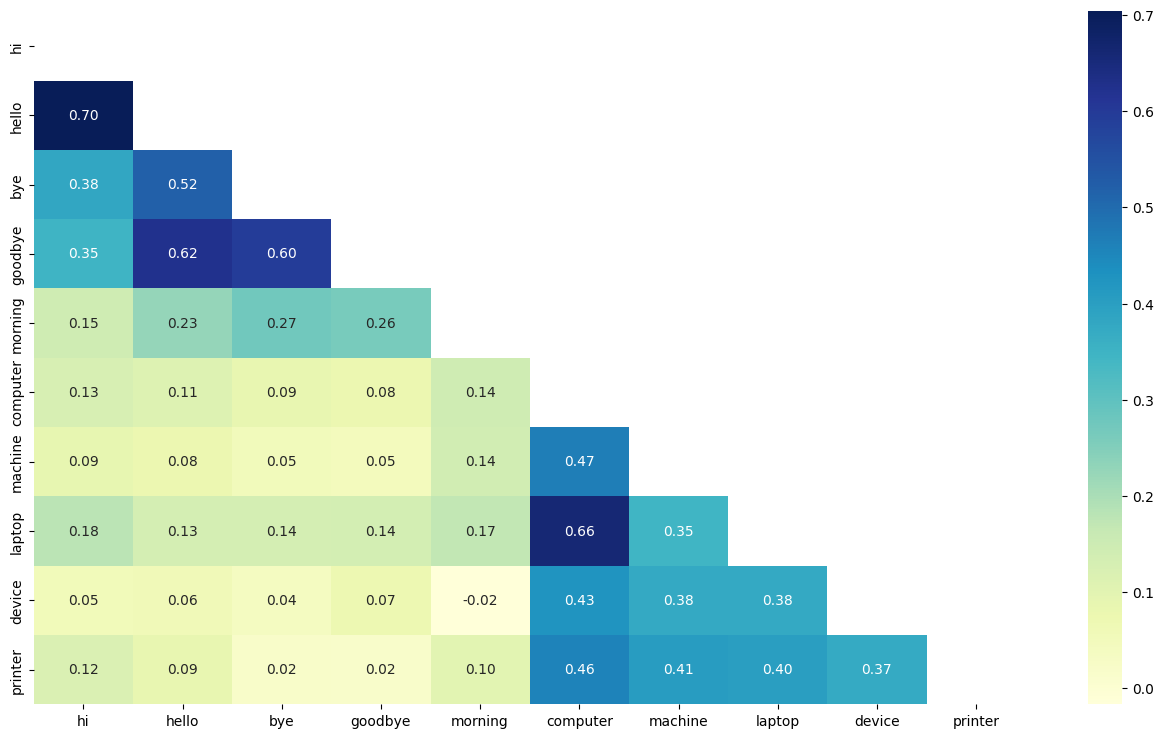

In [ ]:
embeddings_matrix_distance(model_fasttext, words)

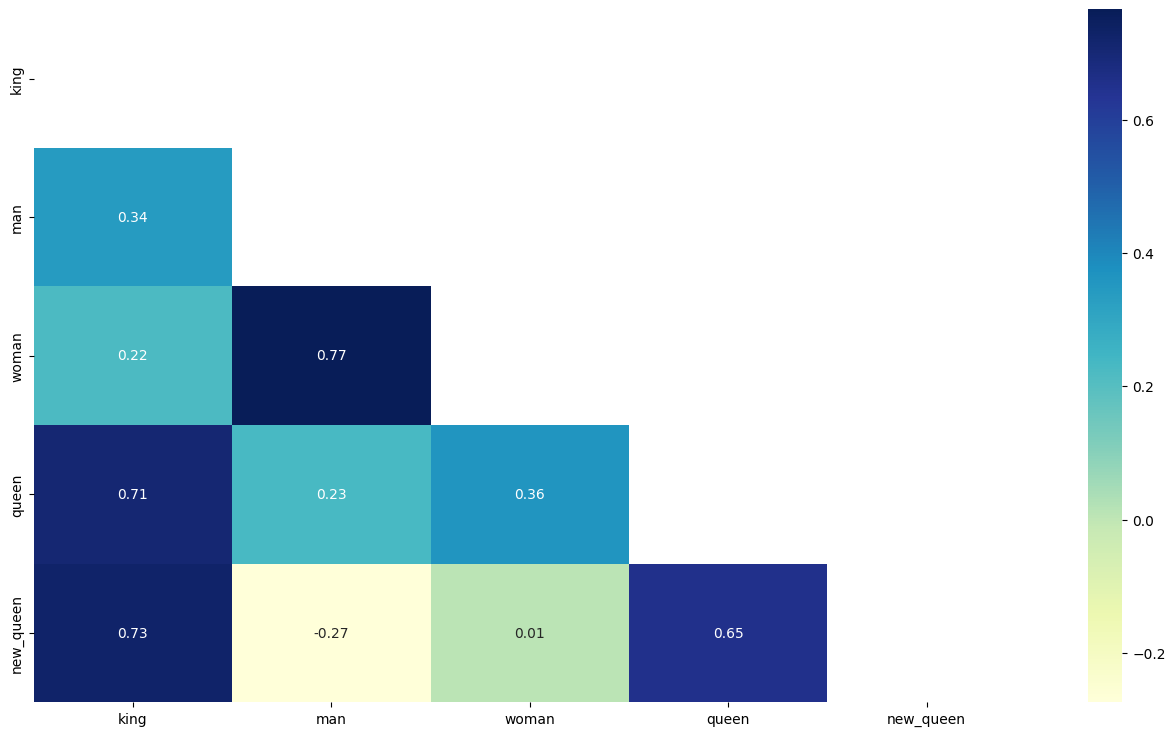

In [ ]:
# probamos un test de analogía
test_words = ['king', 'man', 'woman', 'queen']
test_emb = model_fasttext.get_words_embeddings(test_words)

# king - man + woman
new_queen = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_queen']
new_emb = np.append(test_emb, new_queen.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

In [ ]:
# mas allá de las palabras propuestas, podemos ver cuál sería la palabra
# cuyo embedding es más similar al de 'new_queen'
# para ello vamos a disponibilizar los embeddings como un numpy array
embeddings_fasttext = []
for idx,emb in enumerate(model_fasttext.embeddings):
  embeddings_fasttext.append(emb[1])
embeddings_fasttext = np.array(embeddings_fasttext)

In [ ]:
# calculamos la similaridad de 'new_queen' contra todos los vectores
# puede tardar unos segundos
similarities = np.squeeze(pairwise.cosine_similarity(embeddings_fasttext,np.array([new_queen])))

In [ ]:
# vemos cuáles son los 10 vectores más similares
args_sorted = np.argsort(similarities)[::-1][:10]
for arg in args_sorted:
  print(f'{words_fasttext[arg]}: {similarities[arg]}')

king: 0.7286648154258728
queen: 0.6542776823043823
kings: 0.5410012006759644
queen-mother: 0.5250992178916931
Queen: 0.5074200630187988
royal: 0.5004721879959106
king-: 0.49447429180145264
queens: 0.49149155616760254
monarch: 0.49141061305999756
queenship: 0.48376166820526123


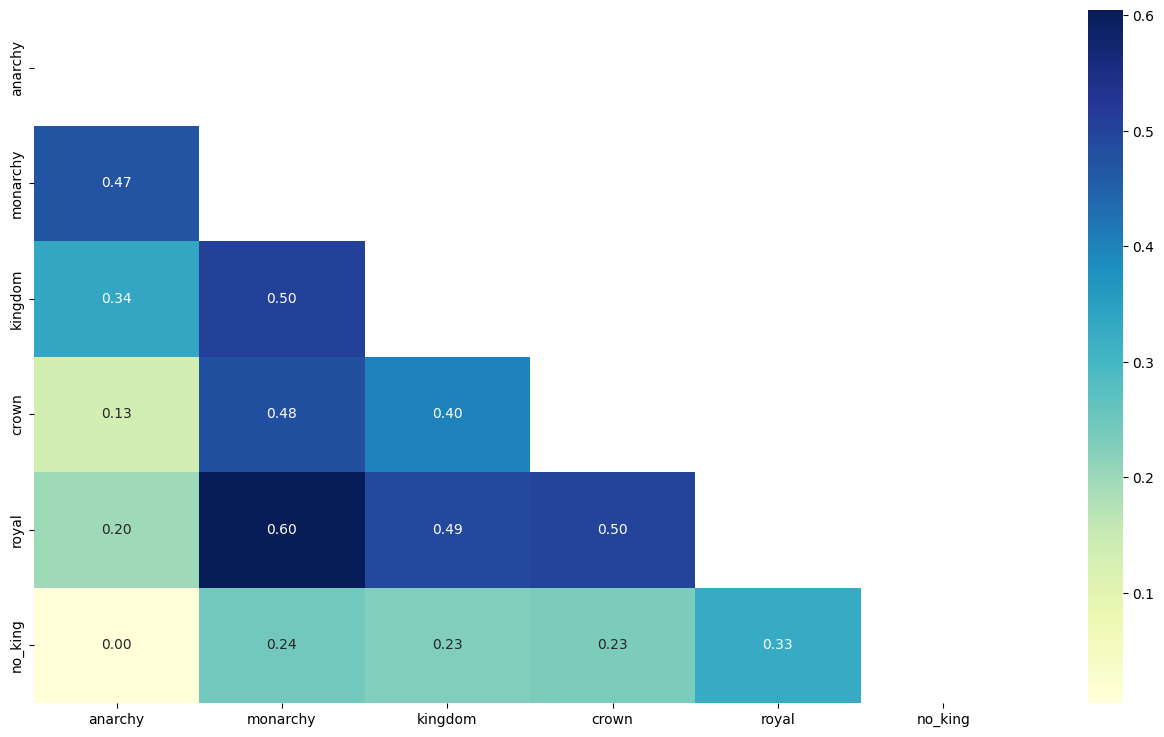

In [ ]:
test_words2 = ['anarchy', 'monarchy', 'kingdom', 'crown', 'royal']
test_emb2 = model_fasttext.get_words_embeddings(test_words2)

# king - man
no_king = test_emb[0] - test_emb[1]

new_words2 = test_words2 + ['no_king']
new_emb2 = np.append(test_emb2, no_king.reshape(1, -1), axis=0)

dist2 = pairwise.cosine_similarity(new_emb2, new_emb2)

plot_matrix_distance(new_words2, dist2)

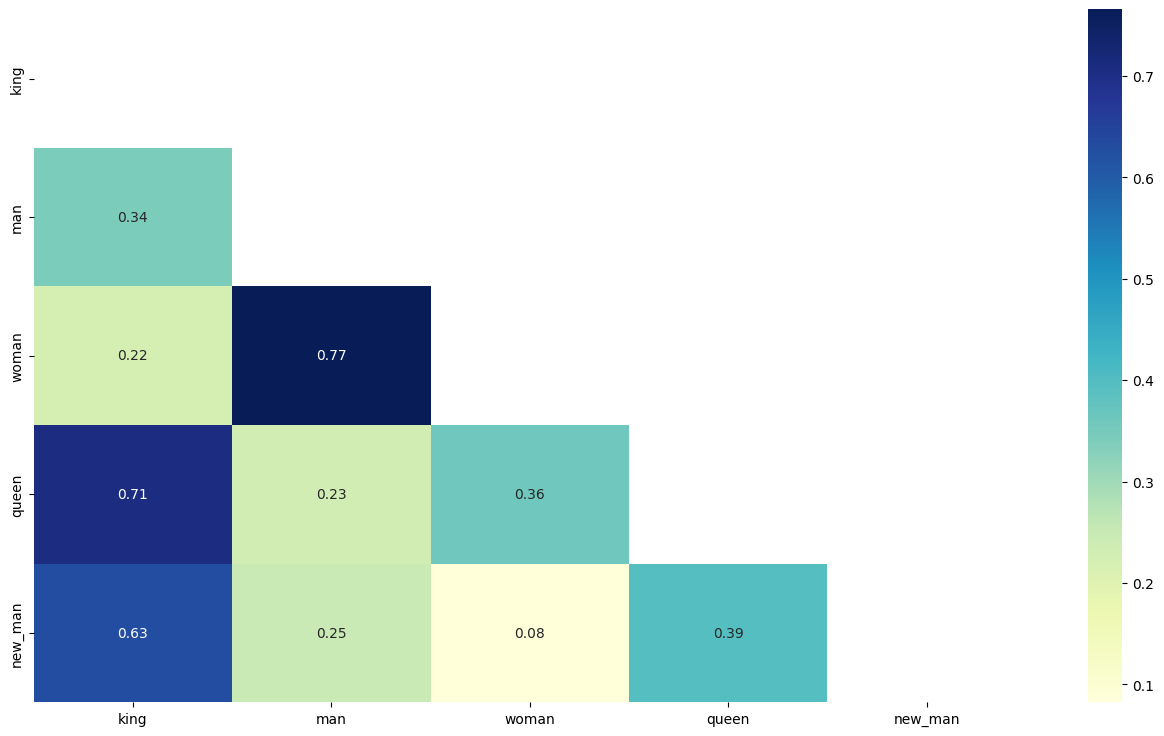

In [ ]:
# king - royal
new_man = test_emb[0] - test_emb2[4]

new_words3 = test_words + ['new_man']
new_emb3 = np.append(test_emb, new_man.reshape(1, -1), axis=0)

dist3 = pairwise.cosine_similarity(new_emb3, new_emb3)

plot_matrix_distance(new_words3, dist3)

## Ejercicio

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

## Custom embedddings con Gensim

El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-07-15 07:30:12--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-07-15 07:30:13--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-07-15 07:30:13--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-8-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


Cantidad de palabras: 10
Dimensiones de los embeddings: (10, 50)


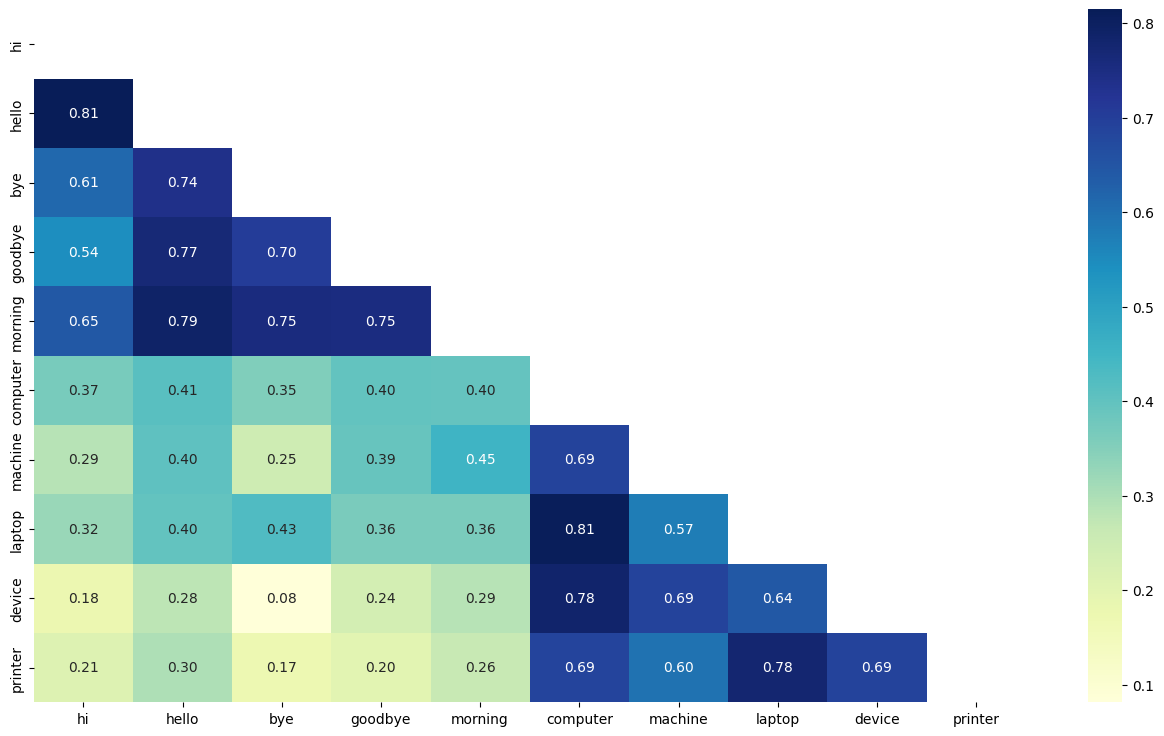

In [ ]:
embeddings_matrix_distance(model_glove, words)

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-7-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


In [ ]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))
# Demos un vistazo
sentence_tokens[:2]

[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

### Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1846


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 445


### Entrenar embeddings

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 113208.15625
Loss after epoch 1: 65953.953125
Loss after epoch 2: 65934.265625
Loss after epoch 3: 65711.96875
Loss after epoch 4: 63872.5
Loss after epoch 5: 64142.46875
Loss after epoch 6: 64058.8125
Loss after epoch 7: 64755.4375
Loss after epoch 8: 62585.5625
Loss after epoch 9: 60415.25
Loss after epoch 10: 59823.625
Loss after epoch 11: 58930.1875
Loss after epoch 12: 57726.4375
Loss after epoch 13: 56493.125
Loss after epoch 14: 55842.5625
Loss after epoch 15: 55862.5
Loss after epoch 16: 51695.8125
Loss after epoch 17: 49815.5
Loss after epoch 18: 49568.125
Loss after epoch 19: 48959.75


(156986, 287740)

### Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["darling"], topn=10)

[('pretty', 0.9087147116661072),
 ('sleep', 0.8649678230285645),
 ('help', 0.8594305515289307),
 ('try', 0.8456019759178162),
 ('cry', 0.8387227654457092),
 ('little', 0.8273633718490601),
 ('not', 0.8181102871894836),
 ('seems', 0.8175203204154968),
 ('twist', 0.8154979348182678),
 ('peace', 0.812263011932373)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)

[('shake', -0.21786975860595703),
 ('our', -0.24495810270309448),
 ('come', -0.2613270878791809),
 ('on', -0.26722386479377747),
 ('bang', -0.27329546213150024),
 ('five', -0.2741836607456207),
 ('six', -0.2774038314819336),
 ('baby', -0.2776353061199188),
 ('work', -0.2790372967720032),
 ('four', -0.2792743146419525)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["four"], topn=10)

[('five', 0.9786694049835205),
 ('three', 0.9761051535606384),
 ('six', 0.966891348361969),
 ('two', 0.9565720558166504),
 ('seven', 0.954232931137085),
 ('sixty', 0.9003373980522156),
 ('one', 0.816501259803772),
 ('us', 0.7762899398803711),
 ('crying', 0.772737979888916),
 ('strawberry', 0.7672452330589294)]

In [ ]:
# Ensayar con una palabra que no está en el vocabulario:
#w2v_model.wv.most_similar(negative=["diedaa"])

KeyError: "Key 'diedaa' not present in vocabulary"

In [ ]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("love")
print(vector_love)

[ 0.17736822  0.21460655 -0.05408018  0.06707036  0.13059464 -0.25713933
  0.00711611  0.26743424 -0.03100746  0.259963    0.21179457 -0.08465387
 -0.26272097  0.308386   -0.07934437 -0.13357355  0.2994755   0.18062147
 -0.13111673 -0.11857472  0.03468326  0.1125607   0.08478875  0.08090881
 -0.17622267  0.03122034 -0.08725598  0.23746666 -0.11507358 -0.29119617
 -0.03650665 -0.3322312   0.23262788  0.10366543 -0.18365337  0.08299578
  0.14315338 -0.19761457 -0.00757894  0.1119568  -0.10421463 -0.13083619
 -0.03264419 -0.04687435  0.11330808  0.10231452 -0.16202034 -0.10347028
  0.03659901 -0.08524423 -0.34872082 -0.02154255  0.25938764  0.16540806
  0.0310861   0.09505633  0.24452917 -0.09859891  0.18298703  0.0645447
  0.016967   -0.3259168  -0.04774074 -0.05418535 -0.04338397 -0.09137302
  0.00889874  0.11636022 -0.25662988  0.05426472  0.08915784  0.04541444
  0.20835714 -0.19101828  0.32210803  0.19337991  0.09080223 -0.00362429
 -0.18664253 -0.07053486 -0.1213743  -0.03477469 -0.

In [ ]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)

[('love', 1.0),
 ('babe', 0.9132986068725586),
 ('someone', 0.8914992809295654),
 ('nothing', 0.8811879754066467),
 ('need', 0.8758756518363953),
 ("didn't", 0.8689683079719543),
 ("there's", 0.8557919859886169),
 ('you', 0.8447725772857666),
 ('feed', 0.8422104716300964),
 ('somebody', 0.8385539054870605)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('babe', 0.9132986068725586),
 ('someone', 0.8914992809295654),
 ('nothing', 0.8811879754066467),
 ('need', 0.8758756518363953),
 ("didn't", 0.8689682483673096),
 ("there's", 0.8557919859886169),
 ('you', 0.8447725772857666),
 ('feed', 0.8422104716300964),
 ('somebody', 0.8385538458824158),
 ('hope', 0.8361446261405945)]

### Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

# Ejercicio

* Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
* Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
* Graficarlos.
* Obtener conclusiones.

##1 - Preprocesamiento

In [ ]:
# Leer el archivo JSONL
data = pd.read_json("hf://datasets/LDJnr/Puffin/Puffin.jsonl", lines=True)
data = data.drop('id', axis=1)

# Crear una lista para almacenar las nuevas filas
rows = []

# Supongamos que la columna que contiene las conversaciones se llama 'conversations'
for conversation in data['conversations']:  # Cambia esto si es necesario
    for turn in conversation:
        rows.append({
            'from': turn['from'],
            'value': turn['value']
        })

# Crear un nuevo DataFrame con las filas transformadas
transformed_data = pd.DataFrame(rows)

# Crear dos DataFrames separados
human_data = transformed_data[transformed_data['from'] == 'human'].reset_index(drop=True)
gpt_data = transformed_data[transformed_data['from'] == 'gpt'].reset_index(drop=True)

# Eliminar la columna 'from' de ambos DataFrames
human_data = human_data.drop(columns=['from'])
gpt_data = gpt_data.drop(columns=['from'])

# Mostrar las primeras filas de cada DataFrame
print("Human Data:")
print(human_data.head())

print("\nGPT Data:")
print(gpt_data.head())

Human Data:
                                               value
0  How do I center a text element vertically in a...
1   Add some spacing between the text and the button
2  Instead of using a spacer how do I give some p...
3  How does the regulation of glycolysis allow fo...
4  "How does the placement of the feet and positi...

GPT Data:
                                               value
0  In Jetpack Compose, you can center a text elem...
1  To add spacing between the `Text` and `Button`...
2  You can add padding to the `Text` element by u...
3  The regulation of glycolysis is essential for ...
4  The placement of the feet and positioning of t...


In [ ]:
sentence_tokens = []
for _, row in human_data[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

##2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 6994


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 7688


## 3 - Entrenar embeddings

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 3617503.5
Loss after epoch 1: 2531029.5
Loss after epoch 2: 2403579.0
Loss after epoch 3: 2231958.0
Loss after epoch 4: 2158987.0
Loss after epoch 5: 2090391.0
Loss after epoch 6: 2015296.0
Loss after epoch 7: 1878294.0
Loss after epoch 8: 1824568.0
Loss after epoch 9: 1780896.0
Loss after epoch 10: 1744344.0
Loss after epoch 11: 1708558.0
Loss after epoch 12: 1677010.0
Loss after epoch 13: 1654908.0
Loss after epoch 14: 1628368.0
Loss after epoch 15: 1609044.0
Loss after epoch 16: 1534414.0
Loss after epoch 17: 1427744.0
Loss after epoch 18: 1414076.0
Loss after epoch 19: 1403124.0


(6237667, 8474720)

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["please"], topn=10)

[('coherent', 0.45842522382736206),
 ('markdown', 0.4505246579647064),
 ('justification', 0.4467005729675293),
 ('alternate', 0.4403669238090515),
 ('4th', 0.4379221498966217),
 ('transcript', 0.43335649371147156),
 ('homework', 0.4307827055454254),
 ('succinct', 0.42804044485092163),
 ('powershell', 0.42792025208473206),
 ('refine', 0.42734494805336)]

In [ ]:
def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Graficar los embedddings en 3D
vecs, labels = reduce_dimensions(w2v_model,3)
fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

# Anotaciones

* NLTK no pasa a minúsculas el texto por su cuenta
* Spacy algunas palabras las reemplaza por su Tag (como " ' ")
* Spacy descompone palabras

Diferentes embeddings capturan diferentes relaciones semánticas y en distinto grado:

* En los embeddings de Glove morning está muy relacionado con los saludos y este comportamiento podría no ser deseado.
* En los embeddings de Fasttext la similitud entre los dos grupos de palabras elegidas no es tan alta.


|Término| Definición|
|-------------------------------|-------------------------|
| Derivación (Stemming)         | El proceso de reducir las palabras a su raíz común mediante la eliminación de sufijos y prefijos. Ejemplo: Reducir "running", "runner" y "runs" a "run". |
| Distancia Coseno              | Una medida de similitud entre dos vectores que calcula el coseno del ángulo entre ellos. Ejemplo: La distancia coseno entre los vectores de "king" y "queen" es pequeña debido a su alta similitud. |
| Embedding                     | Representaciones vectoriales de objetos, comúnmente palabras o frases, en un espacio de alta dimensión. En el contexto de procesamiento del lenguaje natural (NLP), los embeddings son utilizados para capturar las relaciones semánticas entre palabras. Los embeddings permiten que palabras con significados similares tengan representaciones vectoriales cercanas entre sí en el espacio vectorial. |
| FastText                      | Un método para obtener representaciones vectoriales de palabras que tiene en cuenta sub-palabras. [Paper: https://arxiv.org/abs/1607.04606](https://arxiv.org/abs/1607.04606) |
| Filtrado de puntuación        | Eliminar signos de puntuación del texto. |
| Filtrado de puntuación (spaCy) | Eliminar signos de puntuación del texto. |
| Filtrado de stopwords         | Eliminar palabras comunes que no aportan mucho significado. |
| Filtrado de stopwords (spaCy) | Eliminar palabras comunes que no aportan mucho significado. |
| GloVe                         | Un algoritmo de aprendizaje no supervisado para obtener representaciones vectoriales de palabras. [Paper: https://nlp.stanford.edu/pubs/glove.pdf](https://nlp.stanford.edu/pubs/glove.pdf) |
| Lematización (Lemmatization)  | El proceso de transformar las palabras a su forma base o raíz, conocida como lema. Ejemplo: Transformar "running" y "ran" a "run". |
| Lematización                  | Transformar las palabras a su forma base o raíz. |
| Pickle                        | Un formato de datos serializados en Python que permite guardar y cargar objetos de Python. Ejemplo: Guardar embeddings en un archivo para su uso posterior. |
| Pipeline completo de preprocesamiento (NLTK) | Secuencia de tokenización, lematización, filtrado de stopwords y eliminación de puntuación. |
| Pipeline de preprocesamiento  | Una secuencia de pasos para transformar y limpiar los datos de texto antes de analizarlos. Ejemplo: Tokenization → Lemmatization → Remove stopwords → Remove punctuation. |
| Stopwords                     | Palabras comunes en un idioma que se filtran durante el procesamiento del texto porque no aportan mucho significado semántico. Ejemplo: "the", "is", "in", "and". |
| Tokenización (Tokenization)   | El proceso de dividir un texto en unidades más pequeñas llamadas tokens (pueden ser palabras, caracteres o subpalabras). Ejemplo: Dividir "Hello, world!" en ["Hello", ",", "world", "!"]. |
| Tokenización                  | Dividir un texto en tokens individuales. |
| Tokenización y lematización (spaCy) | Dividir el texto en tokens y transformarlos a su forma base. |
| Word Embeddings               | Representación vectorial de palabras que capturan su significado semántico en un espacio continuo. Ejemplo: En un espacio de embedding, las palabras "king", "queen" y "royal" estarán cerca unas de otras. |

Slack
* https://join.slack.com/t/ceaiworkspace/shared_invite/zt-2l9un8yte-yWrXdu7msfCwr32VG6RIgQ

Github
* https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_1/ejercicios/Desafio_1.ipynb

Drive
* https://drive.google.com/drive/u/0/folders/1joS44xgaoCKapc44WmkjcZyjWJh4tQz0

Colab TP1 Hans
* https://colab.research.google.com/drive/1i8RKpItdi4zrKb1aW7OJkdCls0Exgp2b?usp=sharing

Datasets for LLM Training
* https://github.com/Zjh-819/LLMDataHub


NLTK cuenta con una extensiva documentación que vale la pena consultar
https://www.nltk.org